# TensorFlow 2 : ガイド

https://tensorflow.classcat.com/category/tensorflow-2-0/

https://www.tensorflow.org/guide/effective_tf2

# TensorFlow 2.4 : ガイド : 基本 – Eager 実行


Eager Execution は研究や実験のための柔軟な機械学習環境として、以下を提供します。

* 直感的なインタフェース— Python のデータ構造を使用して、コードを自然に記述することができます。小規模なモデルとデータに対してすばやく実験を繰り返すことができます。
* より簡単なデバッグ— ops を直接呼び出すことで、実行中のモデルを調査したり、変更をテストすることができます。 Python 標準のデバッグツールを用いて即座にエラーのレポーティングができます。
* 自然な制御フロー— TensorFlow のグラフ制御フローの代わりに Python の制御フローを利用するため、動的なモデルの作成をシンプルに行うことができます。

Eager Execution は TensorFlow のほとんどのオペレーションとGPUアクセラレーションをサポートします。


In [2]:
import tensorflow as tf

import cProfile

print(tf.__version__)

2.7.0


In [3]:
tf.executing_eagerly()

True

In [4]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


2021-12-23 13:10:36.426556: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Eager Execution は、NumPyと一緒に使うことができます。 NumPy のオペレーションは、tf.Tensorを引数として受け取ることができます。 TensorFlow math operations はPython オブジェクトと Numpy array を tf.Tensor に変換します。 tf.Tensor.numpy メソッドはオブジェクトの値を NumPy の ndarray 形式で返します。

In [5]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [6]:
# ブロードキャストのサポート
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [7]:
# オペレータのオーバーロードがサポートされている
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [8]:
# NumPy valueの使用
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [9]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1
    
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


## Eager Execution による学習

### 勾配の計算

自動微分はニューラルネットワークの学習で利用されるバックプロパゲーションなどの機械学習アルゴリズムの実装を行う上で便利です。 Eager Executionでは、勾配計算をあとで行うためのオペレーションをトレースするためにtf.GradientTape を利用します。

Eager Execution では、学習や勾配計算に, tf.GradientTape を利用できます。これは複雑な学習ループを実行するときに特に役立ちます。

各呼び出し中に異なるオペレーションが発生する可能性があるため、すべての forward-pass オペレーションは**一つの「テープ」に記録されます**。勾配を計算するには、テープを逆方向に再生してから破棄します。特定の tf.GradientTapeは一つのグラデーションしか計算できません。後続の呼び出しは実行時エラーをスローします。

In [11]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


In [12]:
a = np.array([[1.0]])
a

array([[1.]])

In [13]:
a * a

array([[1.]])

In [17]:
w2 = tf.Variable([[1.0]])
loss = w2 * w2
loss

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [20]:
with tf.GradientTape() as tape:
  loss = w2 * w2

grad2 = tape.gradient(loss, w2)
grad2

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.]], dtype=float32)>

### モデル学習

以下の example は MNIST という手書き数字分類を行うマルチレイヤーモデルを作成します。 Eager Execution 環境における学習可能なグラフを構築するためのオプティマイザーとレイヤーAPIを提示します。

In [21]:
# mnist データを取得し、フォーマットする
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [23]:
dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

In [24]:
# モデルを構築する
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

学習を行わずとも、モデルを呼び出して、 Eager Execution により、出力を検査することができます：

In [25]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.12809853  0.00475484 -0.06851784  0.013444   -0.08786147 -0.06274967
   0.00489365 -0.02180025  0.03151297  0.05319133]]


keras モデルは組み込みで学習のループを回すメソッド fit がありますが、よりカスタマイズが必要な場合もあるでしょう。 Eager Executionを用いて実装された学習ループのサンプルを以下に示します：

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [28]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # assertを入れて出力の型をチェックする。
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [29]:
def train():
  for epoch in range(3):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [30]:
train()

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

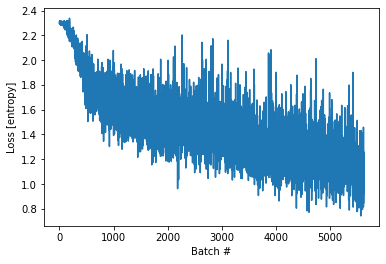

In [31]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

### Variablesとオプティマイザ

tf.Variable オブジェクトは、学習中にアクセスされるミュータブルな tf.Tensor 値を格納し、自動微分を容易にします。 モデルのパラメータは、変数としてクラスにカプセル化できます。

tf.GradientTape と共に tf.Variable を使うことでモデルパラメータはよりカプセル化されます。たとえば、上の の自動微分の例は以下のように書き換えることができます：

In [32]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

# 3 ＊ x + 2を近似するトイデータセット
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# 最適化対象のloss関数
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

# 定義：
# 1. モデル
# 2. モデルパラメータに関する損失関数の導関数
# 3. 導関数に基づいて変数を更新するストラテジ。
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# 学習ループ
for i in range(300):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial loss: 68.322
Loss at step 000: 65.671
Loss at step 020: 29.962
Loss at step 040: 13.979
Loss at step 060: 6.823
Loss at step 080: 3.619
Loss at step 100: 2.184
Loss at step 120: 1.542
Loss at step 140: 1.254
Loss at step 160: 1.125
Loss at step 180: 1.067
Loss at step 200: 1.041
Loss at step 220: 1.029
Loss at step 240: 1.024
Loss at step 260: 1.021
Loss at step 280: 1.020
Final loss: 1.020
W = 2.993413209915161, B = 2.042296886444092


## パフォーマンス

Eager Executionの間、計算は自動的にGPUにオフロードされます。計算を実行するデバイスを指定したい場合は、 tf.device（ '/ gpu：0'） ブロック（もしくはCPUを指定するブロック）で囲むことで指定できます：

In [33]:
import time

def measure(x, steps):
  # TensorFlowはGPUを初めて使用するときに初期化するため、時間計測対象からは除外する。
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # ｔｆ．ｍａｔｍｕｌは、行列乗算が完了する前に戻ることができる。
  # （たとえば、ＣＵＤＡストリームにオペレーションをエンキューした後に戻すことができる）。
  # 以下のx.numpy（）呼び出しは、すべてのキューに入れられたオペレーションが完了したことを確認する。
  # （そして結果をホストメモリにコピーするため、計算時間は単純なmatmulオペレーションよりも多くのことを含む時間になる。）
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# CPU上で実行するとき：
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure(tf.random.normal(shape), steps)))

# GPU上で実行するとき（GPUが利用できれば）：
if tf.test.is_gpu_available():
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 1.389714002609253 secs
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU: not found
